In [1]:
# Authors: GaussPy+ Team, Riley Owens (GitHub: mriener/gausspyplus, mrileyowens)

# This file processes the C-band RRL datacubes through the automatic Gaussian
# decomposition machine learning algorithm GaussPy+ while providing many
# supplementary materials for evaluation of its performance.

In [2]:
import sys
!{sys.executable} -m pip install lmfit
!{sys.executable} -m pip install networkx==2.5

In [3]:
import os

import lmfit

import numpy as np

import pickle

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from multiprocessing import process

from pylab import cm

from gausspyplus.plotting import plot_spectra, get_points_for_colormap, shiftedColorMap
from gausspyplus.training_set import GaussPyTrainingSet
from gausspyplus.training import GaussPyTraining
from gausspyplus.prepare import GaussPyPrepare
from gausspyplus.decompose import GaussPyDecompose
from gausspyplus.spatial_fitting import SpatialFitting
from gausspyplus.finalize import Finalize

from astropy.io import fits
from astropy.wcs import WCS

In [4]:
# Establishing directories
home='/home/jovyan/work/custom/'
data=home+'data'
figs=home+'figs'

In [5]:
# Establishing filepaths
datacubeFile=data+'/G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.fits'
datacubeName=os.path.basename(datacubeFile[:-37])
pickleFile=datacubeName+'.pickle'
print(datacubeName)

G80.74_-0.12


In [6]:
# Function for creating a colormap for the reduced chi squared map
def get_cmap_rchi2(vmin, vmax):
    orig_cmap = matplotlib.cm.RdBu_r
    start, stop = get_points_for_colormap(vmin, vmax, central_val=1.)
    midpoint = (1 - vmin) / (vmax - vmin)
    return shiftedColorMap(orig_cmap, start=0., midpoint=midpoint, stop=stop)

# Function to add axis coordinate labels
def add_style(ax):
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')

In [7]:
#  Initialize the 'GaussPyTrainingSet' class and read in the parameter settings from 'gausspy+.ini'.
training = GaussPyTrainingSet(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  Path to the FITS cube.
training.path_to_file = os.path.join(datacubeFile)
#  Directory to which all files produced by GaussPy+ will get saved.
training.dirpath_gpy = os.path.join(home,'agd',datacubeName)
#  Number of spectra included in the training set. We recommend to have at least 250 spectra for a good training set.
training.n_spectra = 300
training.snr=4.0
#  (Optional) The initial seed that is used to create pseudorandom numbers. Change this value in case the spectra chosen for the training set are not ideal.
#training.random_seed = 111
#  (Optional) We set the upper limit for the reduced chi-square value to a lower number to only include good fits in the training sample
training.rchi2_limit = 1.2
#  (Optional) This will enforce a maximum upper limit for the FWHM value of fitted Gaussian components, in this case 50 channels. We recommended to use this upper limit for the FWHM only for the creation of the training set.
training.max_fwhm = 50.
#  (Optional) Here we specify the filename for the resulting pickled dictionary file. If 'filename_out' is not supplied it will be automatically generated.
#training.filename_out = \
    #'grs-test_field-training_set_{}_spectra.pickle'.format(training.n_spectra)

training.decompose_spectra()  # Create the training set.

#  (Optional) Plot the fitting results of the training set.

#  Filepath to pickled dictionary of the training set.
path_to_training_set = os.path.join(
    training.dirpath_gpy, 'gpy_training', training.filename_out)
#  Directory in which the plots are saved.
path_to_plots = os.path.join(training.dirpath_gpy, 'gpy_training')
plot_spectra(path_to_training_set,
            path_to_plots=path_to_plots,
            training_set=True,
            n_spectra=30  # Plot 30 random spectra of the training set.
            )

decompose 300 spectra ...
using 40 out of 40 cpus


  2%|▏         | 5/300 [00:01<01:04,  4.57it/s]


  2%|▏         | 7/300 [00:02<01:11,  4.11it/s]

  3%|▎         | 8/300 [00:02<01:49,  2.67it/s]

  6%|▋         | 19/300 [00:06<02:10,  2.16it/s]


 12%|█▏        | 37/300 [00:16<02:20,  1.88it/s]

 14%|█▍        | 42/300 [00:21<03:39,  1.17it/s]

 14%|█▍        | 43/300 [00:22<03:45,  1.14it/s]

 26%|██▌       | 77/300 [00:42<02:22,  1.57it/s]

 31%|███▏      | 94/300 [00:50<02:06,  1.63it/s]

 66%|██████▌   | 197/300 [01:49<00:22,  4.64it/s]

100%|██████████| 300/300 [02:47<00:00,  1.79it/s]


SUCCESS


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop-training_set-300_spectra.pickle' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_training'

Plotting...




100%|██████████| 30/30 [00:37<00:00,  1.25s/it]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop-training_set-300_spectra_plots.pdf' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_training'


In [8]:
#  Initialize the 'GaussPyTraining' class and read in the parameter settings from 'gausspy+.ini'.
train = GaussPyTraining(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  Directory in which all files produced by GaussPy+ are saved.
train.dirpath_gpy = os.path.join(home,'agd',datacubeName)
#  Filepath to the training set.
train.path_to_training_set = os.path.join(home,'agd',datacubeName,'gpy_training','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop-training_set-300_spectra.pickle')
#  We select the two-phase-decomposition that uses two smoothing parameters.
train.two_phase_decomposition = True
#  Initial value for the first smoothing parameter.
train.alpha1_initial = 4.0
#  Initial value for the second smoothing parameter.
train.alpha2_initial = 11.0
#  Start the training.
train.training()


GaussPy training
Using training set: /home/jovyan/work/custom/agd/G80.74_-0.12/gpy_training/G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop-training_set-300_spectra.pickle
Training...



4.0, 0.9, -0.0036279172250324593, 0.0
iter 0: F1=96.2%, alpha=[4.0, 11.0], p=[0.00, 0.00]  (Convergence testing begins in 20 iterations)

4.003265125502529, 0.9, -0.0036279172250324593, 0.0026121004020232875
iter 1: F1=96.2%, alpha=[4.0, 10.99], p=[0.00, -0.01]  (Convergence testing begins in 19 iterations)

4.009142351407082, 0.9, -0.0036279172250324593, 0.004701780723642202
iter 2: F1=96.2%, alpha=[4.01, 10.98], p=[0.00, -0.01]  (Convergence testing begins in 18 iterations)

4.017109257633253, 0.9, -0.0036279172250324593, 0.0063735249809369066
iter 3: F1=96.2%, alpha=[4.02, 10.96], p=[0.01, -0.01]  (Convergence testing begins in 17 iterations)

4.026747908116719, 0.9, -0.0036279172250324593, 0.007710920386772813
iter 4: F1=96.2%, alpha=[4.03, 10.95], p=[0.01, -0.01]  (Convergence testing begins in 16 iterations)

4.037723954006021, 0.9, -0.0036279172250324593, 0.008780836711441253
iter 5: F1=96.1%, alpha=[4.04, 10.93], p=[0.01, -0.01]  (Convergence testing begins in 15 iterations)




4.806369595807712, 0.9, 0.0, -0.0005507528878204937
iter 50: F1=96.7%, alpha=[4.81, 10.88], p=[-0.00, -0.00]   (0.00,0.00 < 0.03 for 3 iters [10 required])

4.805818842919892, 0.9, 0.0, -0.00044060231025611074
iter 51: F1=96.7%, alpha=[4.81, 10.88], p=[-0.00, -0.00]   (0.01,0.00 < 0.03 for 4 iters [10 required])

4.8053782406096355, 0.9, 0.0, -0.0003524818482048886
iter 52: F1=96.7%, alpha=[4.81, 10.88], p=[-0.00, -0.00]   (0.02,0.00 < 0.03 for 5 iters [10 required])

4.80502575876143, 0.9, 0.0, -0.0002819854785641951
iter 53: F1=96.7%, alpha=[4.81, 10.88], p=[-0.00, -0.00]   (0.02,0.00 < 0.03 for 6 iters [10 required])

4.804743773282866, 0.9, 0.0, -0.00022558838285107187
iter 54: F1=96.7%, alpha=[4.8, 10.88], p=[-0.00, 0.00]   (0.02,0.00 < 0.03 for 7 iters [10 required])

4.804518184900015, 0.9, 0.0, -0.0001804707062809996
iter 55: F1=96.7%, alpha=[4.8, 10.88], p=[-0.00, 0.00]   (0.02,0.00 < 0.03 for 8 iters [10 required])

4.804337714193734, 0.9, 0.0, -0.0001443765650250839
iter 56

In [9]:
#  Initialize the 'GaussPyPrepare' class and read in the parameter settings from 'gausspy+.ini'.
prepare = GaussPyPrepare(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  Path to the FITS cube.
prepare.path_to_file = os.path.join(datacubeFile)
#  Directory in which all files produced by GaussPy+ are saved.
prepare.dirpath_gpy = os.path.join(home,'agd',datacubeName)
#  Prepare the data cube for the decomposition
prepare.prepare_cube()
#  (Optional) Produce a FITS image with the estimated root-mean-square values
#prepare.produce_noise_map()

#  (Optional) Plot some of the spectra and the estimated signal ranges

#  Filepath to pickled dictionary of the prepared data.
path_to_pickled_file = os.path.join(home,'agd',datacubeName,'gpy_prepared','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle')
#  Directory in which the plots are saved.
path_to_plots = os.path.join(home,'agd',datacubeName,'gpy_plots')
#  Here we select a subregion of the data cube, whose spectra we want to plot.
pixel_range = {'x': [100, 104], 'y': [67, 71]}
plot_spectra(path_to_pickled_file, path_to_plots=path_to_plots,signal_ranges=True, pixel_range=pixel_range)


calculating average rms from data...


100%|██████████| 1000/1000 [00:00<00:00, 1742.93it/s]


>> calculated rms value of 0.028 from data

GaussPy preparation

preparing GaussPy cube...
Using 40 of 40 cpus


100%|██████████| 57.6k/57.6k [01:22<00:00, 695it/s]  
57597it [00:00, 262688.73it/s]


SUCCESS



57600it [00:00, 91216.70it/s]



pickle dump dictionary...
For GaussPyDecompose: 'path_to_pickle_file' = '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_prepared/G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle'

Plotting...




100%|██████████| 25/25 [00:02<00:00,  8.73it/s]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_plots.pdf' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_plots'


In [10]:
#  Initialize the 'GaussPyDecompose' class and read in the parameter settings from 'gausspy+.ini'.
decompose = GaussPyDecompose(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  Filepath to pickled dictionary of the prepared data.
decompose.path_to_pickle_file = os.path.join(home,'agd',datacubeName, 'gpy_prepared', 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle')
#  First smoothing parameter
decompose.alpha1 = 4.8 
#  Second smoothing parameter
decompose.alpha2 = 10.89
#  Suffix for the filename of the pickled dictionary with the decomposition results.
decompose.suffix = '_g+'
#  Start the decomposition.
decompose.decompose()

#  (Optional) Produce a FITS image showing the number of fitted components
decompose.produce_component_map()
#  (Optional) Produce a FITS image showing the reduced chi-square values
decompose.produce_rchi2_map()

#  (Optional) Plot some of the spectra and the decomposition results

#  Filepath to pickled dictionary of the prepared data.
path_to_pickled_file = decompose.path_to_pickle_file
#  Filepath to pickled dictionary with the decomposition results
path_to_decomp_pickle = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin.pickle')
#  Directory in which the plots are saved.
path_to_plots = os.path.join(home,'agd',datacubeName,'gpy_plots')
#  Here we select a subregion of the data cube, whose spectra we want to plot.
pixel_range = {'x': [30, 34], 'y': [25, 29]}
plot_spectra(path_to_pickled_file, path_to_plots=path_to_plots,
    path_to_decomp_pickle=path_to_decomp_pickle,
    signal_ranges=True, pixel_range=pixel_range)


pickle load 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle'...



GaussPy decomposition

decomposition settings:
GaussPy:
Two phase decomposition: True
alpha1: 4.8
alpha2: 10.89
SNR1: 3.0
SNR2: 3.0

improve_fitting: True
min_fwhm: 1.0
max_fwhm: None
snr: 3.0
snr_fit: 1.5
significance: 5.0
snr_negative: 3.0
rchi2_limit: None
max_amp_factor: 1.1
neg_res_peak: True
broad: True
blended: True
fwhm_factor: 2.0
separation_factor: 0.8493218
exclude_means_outside_channel_range: True
min_pvalue: 0.01
max_ncomps: None

decomposing data...
using 40 out of 40 cpus


100%|██████████| 57.6k/57.6k [01:40<00:00, 571it/s]  
57599it [00:00, 208702.29it/s]



pickle dump GaussPy final results...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin.pickle' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_decomposed'

making component map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_component_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_rchi2_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

Plotting...




100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_plots.pdf' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_plots'


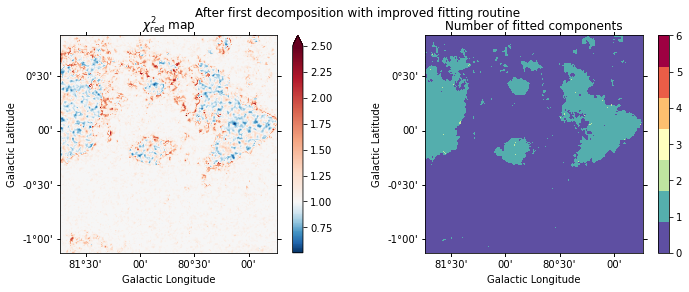

In [11]:
filepath = os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After first decomposition with improved fitting routine')
fig.savefig(os.path.join(home,'agd',datacubeName,'gpy_plots','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_component_map_rchi2_map.pdf'))

plt.show()

In [12]:
#  Initialize the 'SpatialFitting' class and read in the parameter settings from 'gausspy+.ini'.
sp = SpatialFitting(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  filepath to the pickled dictionary of the prepared data
sp.path_to_pickle_file = os.path.join(home,'agd',datacubeName,'gpy_prepared','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle')
#  Filepath to the pickled dictionary of the decomposition results
sp.path_to_decomp_file = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin.pickle')
#  Try to refit blended fit components
sp.refit_blended = True
#  Try to refit spectra with negative residual features
sp.refit_neg_res_peak = True
#  Try to refit broad fit components
sp.refit_broad = True
#  Flag spectra with non-Gaussian distributed residuals
sp.flag_residual = True
#  Do not try to refit spectra with non-Gaussian distributed residuals
sp.refit_residual = False
#  Try to refit spectra for which the number of fit components is incompatible with its direct neighbors
sp.refit_ncomps = True
#  We set the maximum allowed difference in the number of fitted components compared to the weighted median of all immediate neighbors to 1
sp.max_diff_comps = 1
# We set the maximum allowed difference in the number of fitted components between individual neighboring spectra to 2
sp.max_jump_comps = 2
# We will flag and try to refit all spectra which show jumps in the number of components of more than 2 to at least two direct neighbors
sp.n_max_jump_comps = 1
# Maximum difference in offset positions of fit components for grouping.
sp.mean_separation = 2.
# Maximum difference in FWHM values of fit components for grouping.
sp.fwhm_separation = 4.

#  Start phase 1 of the spatially coherent refitting
sp.spatial_fitting()

#  (Optional) Plot maps of the reduced chi-square values and the number of fitted components

#  Initialize the 'GaussPyDecompose' class and read in the parameter settings from 'gausspy+.ini'.
decompose = GaussPyDecompose(config_file='gausspy+.ini')
#  Filepath to pickled dictionary of the prepared data.
decompose.path_to_pickle_file = sp.path_to_pickle_file
#  Filepath to the pickled dictionary with the decomposition results
path_to_decomp_pickle = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1.pickle')
#  Load the decomposition results
decompose.load_final_results(path_to_decomp_pickle)
#  Produce a FITS image showing the number of fitted components
decompose.produce_component_map()
#  Produce a FITS image showing the reduced chi-square values
decompose.produce_rchi2_map()

#  (Optional) Plot some of the spectra and the decomposition results

#  Filepath to pickled dictionary of the prepared data.
path_to_pickled_file = sp.path_to_pickle_file
#  Directory in which the plots are saved.
path_to_plots = os.path.join(home,'agd',datacubeName,'gpy_plots')
#  Here we select a subregion of the data cube, whose spectra we want to plot.
pixel_range = {'x': [30, 34], 'y': [25, 29]}
plot_spectra(path_to_pickled_file, path_to_plots=path_to_plots,path_to_decomp_pickle=path_to_decomp_pickle,signal_ranges=True, pixel_range=pixel_range)


Spatial refitting - Phase 1

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

For phase 1:
Exclude flagged spectra as possible refit solutions in first refit attempts: False
Use also flagged spectra as refit solutions in case no new best fit could be obtained from unflagged spectra: False

Refitting:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   try to refit if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: Fal

100%|██████████| 36.0/36.0 [00:01<00:00, 19.2it/s]
36it [00:00, 99013.08it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 39 spectra
Successfully refitted 33 spectra (84.62%)

***

determine spectra that need refitting...

23 out of 57600 spectra (0.04%) selected for refitting:
 - 1 spectra w/ blended components (1 flagged)
 - 0 spectra w/ negative residual feature (0 flagged)
 - 22 spectra w/ broad feature (22 flagged)
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value (0 flagged)
 - 0 spectra w/ residual not passing normality test (11983 flagged)
 - 0 spectra w/ differing number of components (0 flagged)

start refit iteration #2...
Using 40 of 40 cpus


100%|██████████| 20.0/20.0 [00:00<00:00, 166it/s]
20it [00:00, 55260.92it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 2 spectra
Successfully refitted 2 spectra (100.00%)

***

determine spectra that need refitting...

22 out of 57600 spectra (0.04%) selected for refitting:
 - 0 spectra w/ blended components (0 flagged)
 - 0 spectra w/ negative residual feature (0 flagged)
 - 22 spectra w/ broad feature (22 flagged)
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value (0 flagged)
 - 0 spectra w/ residual not passing normality test (11983 flagged)
 - 0 spectra w/ differing number of components (0 flagged)

start refit iteration #3...
Using 40 of 40 cpus


100%|██████████| 19.0/19.0 [00:00<00:00, 1.35kit/s]
19it [00:00, 75251.91it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 0 spectra
Successfully refitted 0 spectra (0.00%)

***

determine spectra that need refitting...

22 out of 57600 spectra (0.04%) selected for refitting:
 - 0 spectra w/ blended components (0 flagged)
 - 0 spectra w/ negative residual feature (0 flagged)
 - 22 spectra w/ broad feature (22 flagged)
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value (0 flagged)
 - 0 spectra w/ residual not passing normality test (11983 flagged)
 - 0 spectra w/ differing number of components (0 flagged)
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_decomposed'



pickle load 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle'...



GaussPy decomposition

pickle load final GaussPy results...

making component map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_component_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_rchi2_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

Plotting...




100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_plots.pdf' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_plots'


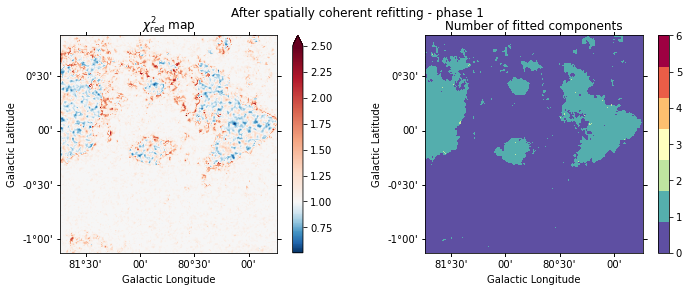

In [13]:
filepath = os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
header = fits.getheader(filepath)
wcs = WCS(header)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After Phase 1 spatially coherent refitting')
fig.savefig(os.path.join(home,'agd',datacubeName,'gpy_plots','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1_component_map_rchi2_map.pdf'))

plt.show()

In [14]:
#  Initialize the 'SpatialFitting' class and read in the parameter settings from 'gausspy+.ini'.
sp = SpatialFitting(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  filepath to the pickled dictionary of the prepared data
sp.path_to_pickle_file = os.path.join(home,'agd',datacubeName,'gpy_prepared','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle')
#  Filepath to the pickled dictionary of the decomposition results
sp.path_to_decomp_file = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p1.pickle')
#  Try to refit blended fit components
sp.refit_blended = True
#  Try to refit spectra with negative residual features
sp.refit_neg_res_peak = True
#  Try to refit broad fit components
sp.refit_broad = True
#  Flag spectra with non-Gaussian distributed residuals
sp.flag_residual = True
#  Do not try to refit spectra with non-Gaussian distributed residuals
sp.refit_residual = False
#  Try to refit spectra for which the number of fit components is incompatible with its direct neighbors
sp.refit_ncomps = True
#  We set the maximum allowed difference in the number of fitted components compared to the weighted median of all immediate neighbors to 1
sp.max_diff_comps = 1
#  We set the maximum allowed difference in the number of fitted components between individual neighboring spectra to 2
sp.max_jump_comps = 2
#  We will flag and try to refit all spectra which show jumps in the number of components of more than 2 to at least two direct neighbors
sp.n_max_jump_comps = 1
#  Maximum difference in offset positions of fit components for grouping. We use double the value than in phase 1.
sp.mean_separation = 4.
#  Maximum difference in FWHM values of fit components for grouping.
sp.fwhm_separation = 4.
#  Minimum required weight for neighboring features; for the default settings this would require that either the two immediate horizontal or vertical neighbors show a common feature or one of the immediate horizontal or vertical neighbors in addition to the two outermost neighbors in the same direction
sp.min_weight = 0.6

#  Start phase 2 of the spatially coherent refitting
sp.spatial_fitting(continuity=True)

#  (Optional) Plot maps of the reduced chi-square values and the number of fitted components

#  Initialize the 'GaussPyDecompose' class and read in the parameter settings from 'gausspy+.ini'.
decompose = GaussPyDecompose(config_file='gausspy+.ini')
#  Filepath to pickled dictionary of the prepared data.
decompose.path_to_pickle_file = sp.path_to_pickle_file
#  Filepath to the pickled dictionary with the decomposition results
path_to_decomp_pickle = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2.pickle')
#  Load the decomposition results
decompose.load_final_results(path_to_decomp_pickle)
#  Produce a FITS image showing the number of fitted components
decompose.produce_component_map()
#  Produce a FITS image showing the reduced chi-square values
decompose.produce_rchi2_map()

#  (Optional) Plot some of the spectra and the decomposition results

#  Filepath to pickled dictionary of the prepared data.
path_to_pickled_file = sp.path_to_pickle_file
#  Directory in which the plots are saved.
path_to_plots = os.path.join(home,'agd',datacubeName,'gpy_plots')
#  Here we select a subregion of the data cube, whose spectra we want to plot.
pixel_range = {'x': [30, 34], 'y': [25, 29]}
plot_spectra(path_to_pickled_file, path_to_plots=path_to_plots,path_to_decomp_pickle=path_to_decomp_pickle,signal_ranges=True, pixel_range=pixel_range)


Spatial refitting - Phase 2

Flagging:
 - Blended components: True
 - Negative residual features: True
 - Broad components: True
   flagged if FWHM of broadest component in spectrum is:
   >= 2.0 times the FWHM of second broadest component
   or
   >= 2.0 times any FWHM in >= 50% of its neigbors
 - High reduced chi2 values (> None): False
 - Non-Gaussian distributed residuals: True
 - Differing number of components: True

threshold for required components: 0.833

 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 22 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11983 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

determine neighbors for all spectra...


57600it [00:40, 1405.91it/s]



start refit iteration #1...
Using 40 of 40 cpus


100%|██████████| 57.6k/57.6k [00:45<00:00, 1.28kit/s]
57597it [00:00, 197857.39it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 5 spectra
Successfully refitted 3 spectra (60.00%)

***

threshold for required components: 0.833

 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 22 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11982 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #2...
Using 40 of 40 cpus


100%|██████████| 45.0/45.0 [00:00<00:00, 28.7kit/s]
45it [00:00, 160359.97it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 0 spectra
Successfully refitted 0 spectra (0.00%)

***

threshold for required components: 0.833

 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 22 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11982 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #3...
Using 40 of 40 cpus


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]

SUCCESS

Results of the refit iteration:
Tried to refit 0 spectra
Successfully refitted 0 spectra (0.00%)

***

threshold for required components: 0.667



 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 22 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11982 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #4...
Using 40 of 40 cpus


100%|██████████| 57.6k/57.6k [00:45<00:00, 1.27kit/s]
57597it [00:00, 196732.08it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 8 spectra
Successfully refitted 1 spectra (12.50%)

***

threshold for required components: 0.667

 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 23 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11982 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #5...
Using 40 of 40 cpus


100%|██████████| 13.0/13.0 [00:00<00:00, 1.10kit/s]
13it [00:00, 58378.96it/s]


SUCCESS

Results of the refit iteration:
Tried to refit 0 spectra
Successfully refitted 0 spectra (0.00%)

***

threshold for required components: 0.667

 Flags:
 - 0 spectra w/ blended components
 - 0 spectra w/ negative residual feature
 - 23 spectra w/ broad feature
   (info: 0 spectra w/ a FWHM > 133 channels)
 - 0 spectra w/ high rchi2 value
 - 11982 spectra w/ residual not passing normality test
 - 0 spectra w/ differing number of components

check which spectra require refitting...

start refit iteration #6...
Using 40 of 40 cpus


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]

SUCCESS

Results of the refit iteration:
Tried to refit 0 spectra
Successfully refitted 0 spectra (0.00%)

***


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_decomposed'



pickle load 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle'...



GaussPy decomposition

pickle load final GaussPy results...

making component map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_component_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

making reduced chi2 map...
SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_rchi2_map.fits' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_maps'

Plotting...




100%|██████████| 25/25 [00:07<00:00,  3.50it/s]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_plots.pdf' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_plots'


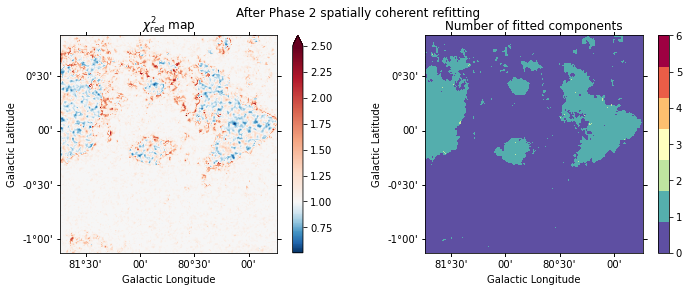

In [17]:
filepath = os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_rchi2_map.fits')
rchi2 = fits.getdata(filepath)
wcs = WCS(fits.getheader(filepath))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw=dict(projection=wcs))

ax = axes.flatten()[0]

vmin = min(rchi2.flatten())
vmax = 2.5
new_cmap = get_cmap_rchi2(vmin, vmax)

img_rchi2 = ax.imshow(rchi2, cmap=new_cmap, vmin=vmin, vmax=vmax)
fig.colorbar(img_rchi2, ax=ax, extend='max')
ax.set_title('$\chi_{\mathrm{red}}^{2}$ map')
add_style(ax)

ax = axes.flatten()[1]

ncomps = fits.getdata(os.path.join(home,'agd',datacubeName,'gpy_maps','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_component_map.fits'))

vmax = 6
new_cmap = cm.get_cmap('Spectral_r', vmax + 1)

img_ncomps = ax.imshow(ncomps, cmap=new_cmap, vmin=0, vmax=vmax)
fig.colorbar(img_ncomps, ax=ax)
ax.set_title('Number of fitted components')
add_style(ax)

fig.suptitle('After Phase 2 spatially coherent refitting')
fig.savefig(os.path.join(home,'agd',datacubeName,'gpy_plots','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_component_map_rchi2_map.pdf'))

plt.show()

In [16]:
#  Initialize the 'Finalize' class and read in the parameter settings from 'gausspy+.ini'.
finalize = Finalize(config_file='gausspy+.ini')

#  The following lines will override the corresponding parameter settings defined in 'gausspy+.ini'.

#  filepath to the pickled dictionary of the prepared data
finalize.path_to_pickle_file = os.path.join(home,'agd',datacubeName,'gpy_prepared','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop.pickle')
#  Filepath to the pickled dictionary of the decomposition results
finalize.path_to_decomp_file = os.path.join(home,'agd',datacubeName,'gpy_decomposed','G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2.pickle')

finalize.finalize_dct()
finalize.make_table()


check which spectra require refitting...

determine neighbors for all spectra...


57600it [00:44, 1306.17it/s]


start refit iteration #1...
Using 40 of 40 cpus



100%|██████████| 57.6k/57.6k [00:44<00:00, 1.29kit/s]
57597it [00:00, 218671.12it/s]


SUCCESS
Using 40 of 40 cpus


100%|██████████| 57.6k/57.6k [00:29<00:00, 1.96kit/s]
57597it [00:00, 192316.95it/s]


SAVED FILE: 'G80.74_-0.12_regrid_smo_avg_line_cut_bl_drop_g+_fit_fin_sf-p2_finalized.dat' in '/home/jovyan/work/custom/agd/G80.74_-0.12/gpy_decomposed'


x_pos,y_pos,GLON,GLAT,amp,e_amp,VLSR,e_VLSR,vel_disp,e_vel_disp,int_tot,e_int_tot,rms,pvalue,aicc,rchi2,ncomps,ncomp_wmedian,ncomp_jumps,flag_blended,flag_neg_res_peak,flag_broad,flag_centroid
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32
64,1,81.1984,-1.1117,0.0511,0.0111,-10.2340,0.7757,3.1029,0.7757,0.3977,0.2071,0.0294,0.0469,-736.8544,1.0738,1,0,0,0,0,0,0
56,4,81.2651,-1.0867,0.0673,0.0143,-12.5882,0.4358,1.7777,0.4358,0.2998,0.1529,0.0291,0.0208,-793.1450,1.0953,1,0,0,0,0,0,0
219,4,79.9065,-1.0867,0.0345,0.0063,-9.3768,1.1705,5.5360,1.1705,0.4788,0.2076,0.0228,0.1674,-882.2932,0.8707,1,0,0,0,0,0,0
69,5,81.1567,-1.0783,0.0417,0.0075,-6.8188,1.1006,5.3345,1.1006,0.5581,0.2354,0.0268,0.7017,-2909.6096,0.9762,1,0,0,0,0,0,0
69,6,81.1567,-1.0700,0.0422,0.0078,-7.1156,0.9948,4.6302,0.9948,0.4898,0.2159,0.0272,0.2002,-759.7416,1.0083,1,1,0,0,0,0,0
70,6,81.1484,-1.0700,0.0414,0.0079,-6.5967,1.0129,4.5884,1.0129,0.4761,0.2164,0.0258,0.3530,-748.2021,1.2490,1,0,0,0,0,0,0
69,7,81.1567,-1.0617,0.0408,0.0081,-7.1651,0.9757,4.2378,0.9757,0.4332,0.2059,0.0268,0.2399,-766.4152,0.9778,1,0,0,0,0,0,0
70,7,81.1484,-1.0617,0.0412,0.0084,-6.9996,1.0088,4.2834,1.0088,0.4428,0.2157,0.0265,0.3164,-753.1753,1.1333,1,0,0,0,0,0,0
34,9,81.4484,-1.0450,0.0441,0.0075,-7.9202,1.2635,6.4592,1.2635,0.7140,0.2844,0.0294,0.2358,-926.4542,0.7681,1,0,0,0,0,0,0
